# Telecom Churn Analysis

Churn is a one of the biggest problem in  the telecom industry. Research has shown that the average monthly churn rate among the top 4 wireless carriers in the US is 1.9% - 2%. In this analysis I have tried to first develop some hypothesis by cinducing a detailed exploratory data analysis for churn in the Telecom Industry and used predictive analytics to accurately predict the customers wh are likely to churn. 

I have explored the following classficiation techniques and compared their accuracy and other metrics such as ROC-AUC score, True Positive Rate and False Positive Rate.

Models Explored - 


1. Logistic Regression
2. Random Forests
3. Supprt Vector Machines (SVMs)
4. ADABoost
5. Light GBM
6. XG Boost
7. Decision Tree

Overall Approach is as follows - 

1. Data Preprocessing - To check for any missing values, correlated variables and dummy encoding
2. EDA to develop hypothesis
3. Scaling data to make sure we are using scaled data to improve accuracy
4. Splitting data into train & test datasets
5. Training each of the above models using cross validation
6. Testing the accuracy on test data and plotting ROC curves for each of the models
7. Comparing each model on various metrics and identifying the important parameters which help explain churn.

### Importing Packages

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

sns.set(style = 'white')
import shap
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from datetime import datetime
import lightgbm as lgbm
from sklearn.svm import SVC
import warnings

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings

from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

warnings.filterwarnings('ignore') #ignore warning messages 


# Input data files are available in the "../input/" directory.

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


In [3]:
data = pd.read_csv('C:/Users/niran/Documents/jupyter/Telecom Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
data.shape

(7043, 21)

In [5]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [6]:
data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [7]:
# Checking the data types of all the columns
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
numeric_features = [feature for feature in data.columns if data[feature].dtype != 'object']
cat_features = [feature for feature in data.columns if data[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print("Categorical featues:", cat_features)

Numerical features:  ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical featues: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


In [9]:
# Converting Total Charges to a numerical data type.
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
#Filling missing values 
data.fillna(data.select_dtypes('float64').median(), inplace=True)
#Remove customer IDs from the data set
df2 = data.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0       1           29.85         29.85      0              1   
1              0      34           56.95       1889.50      0              0   
2              0       2           53.85        108.15      1              0   
3              0      45           42.30       1840.75      0              0   
4              0       2           70.70        151.65      1              1   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  ...  \
0            0           0            1              1  ...   
1            1           1            0              1  ...   
2            1           1            0              1  ...   
3            1           1            0              1  ...   
4            0           1            0              1  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   
1                    0                        0                  1   
2                    0                        1                  0   
3                    0                        0                  1   
4                    0                        1                  0   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0                  0                    0                     1   
1                  0                    1                     0   
2                  0                    0                     1   
3                  0                    1                     0   
4                  0                    0                     1   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 46 columns]

<AxesSubplot:>

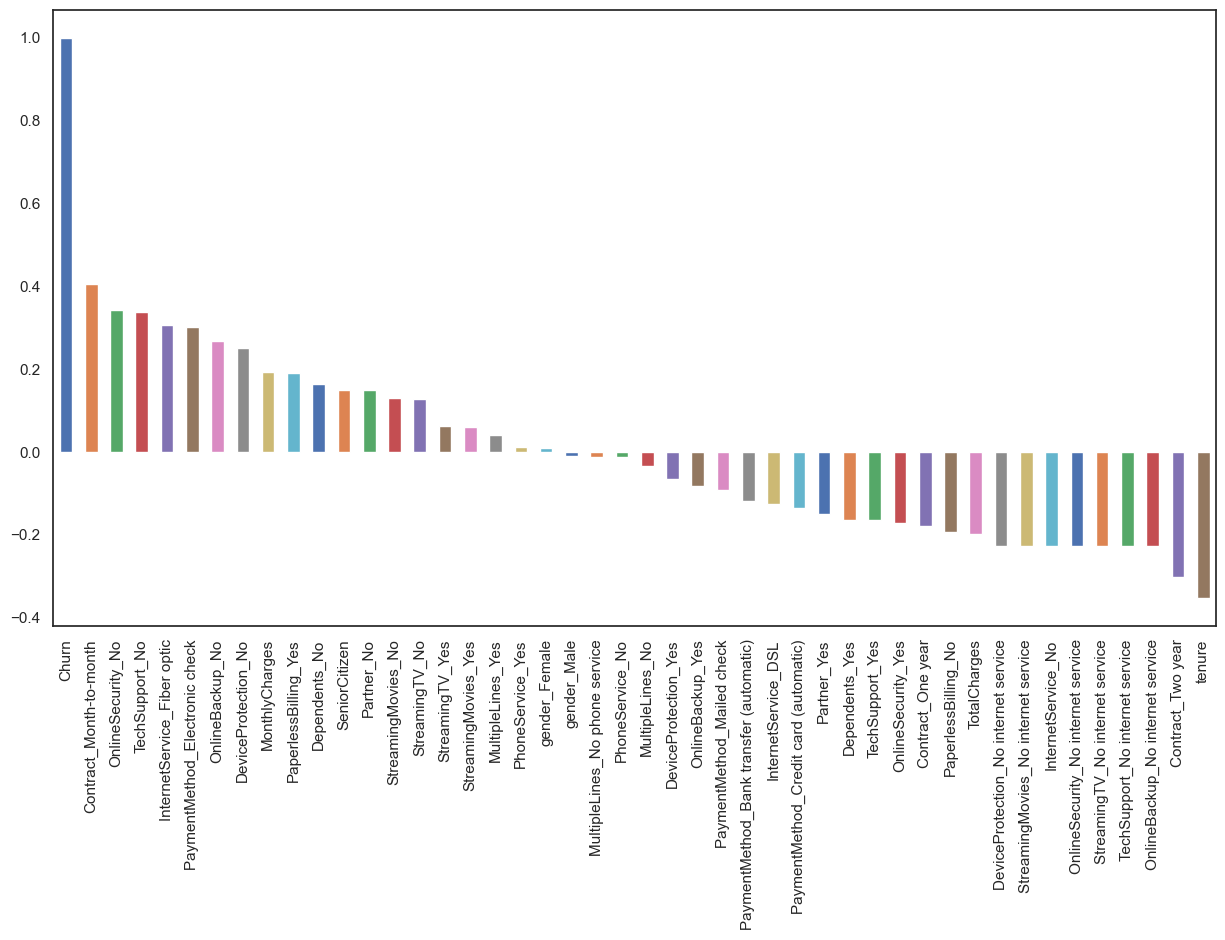

In [11]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar',color = sns.color_palette())

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. While, tenure, two year contracts seem to be negatively correlated with churn.

Interestingly, services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

We will explore the patterns for the above correlations below before we delve into modelling and identifying the important variables.

## Data Exploration

Let us first start with exploring our data set, to better understand the patterns in the data and potentially form some hypothesis. First we will look at the distribution of individual variables and then slice and dice our data for any interesting trends.

**A.)** ***Demographics*** - Let us first understand the gender, age range, patner and dependent status of the customers

1. **Gender Distribution** - About half of the customers in our data set are male while the other half are female

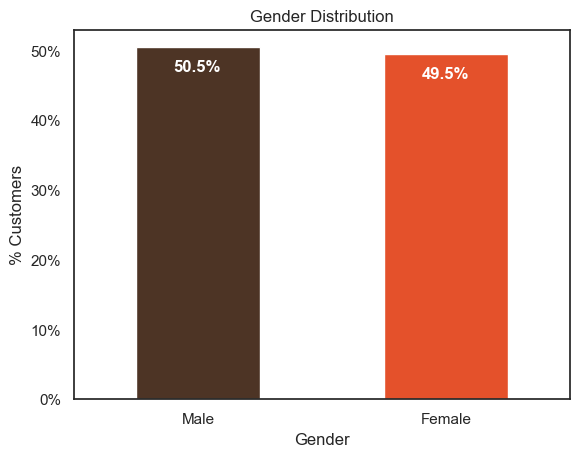

In [12]:
colors = ['#4D3425','#E4512B']
ax = (data['gender'].value_counts()*100.0 /len(data)).plot(kind='bar',stacked = True,rot = 0,color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')


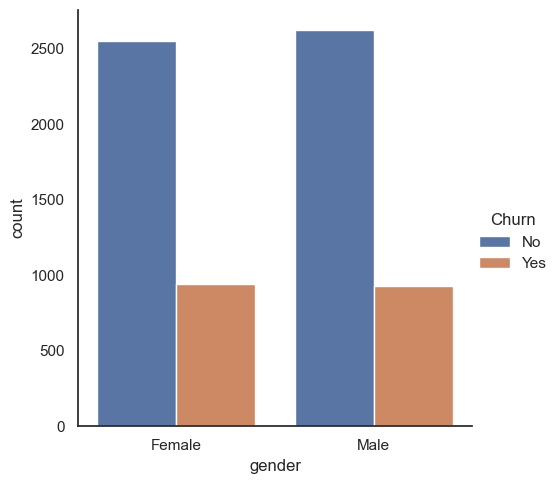

In [13]:
ax1 = sns.catplot(x="gender", kind="count", hue="Churn", data=data,
                  estimator=lambda x: sum(x==0)*100.0/len(x))

2. **% Senior Citizens** - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.


Text(0.5, 1.0, '% of Senior Citizens')

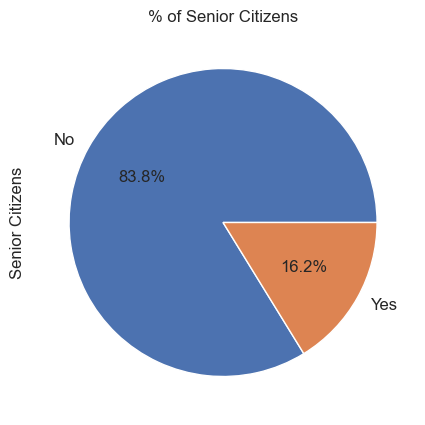

In [14]:
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

3. **Partner and dependent status**  - About 50% of the customers have a partner, while only 30% of the total customers have dependents. 

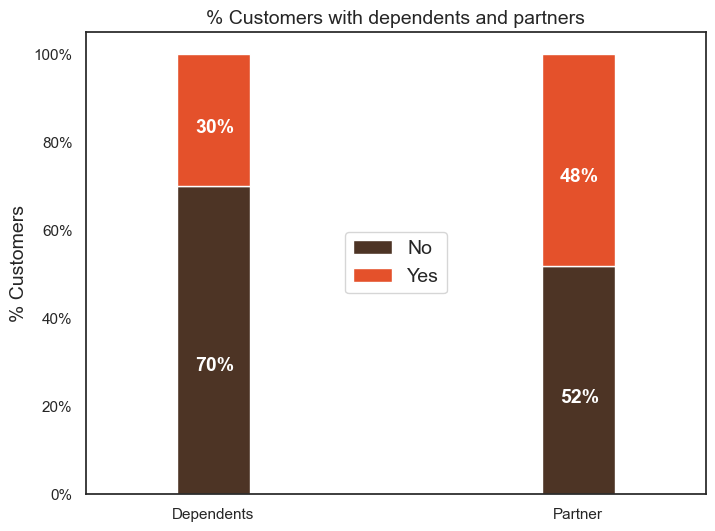

In [15]:
df2 = pd.melt(data, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(data)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**What would be interesting is to look at the % of customers, who have partners, also have dependents. We will explore this next.**

Interestingly, among the customers who have a partner, only about half of them also have a dependent, while other half do not have any independents. Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents.

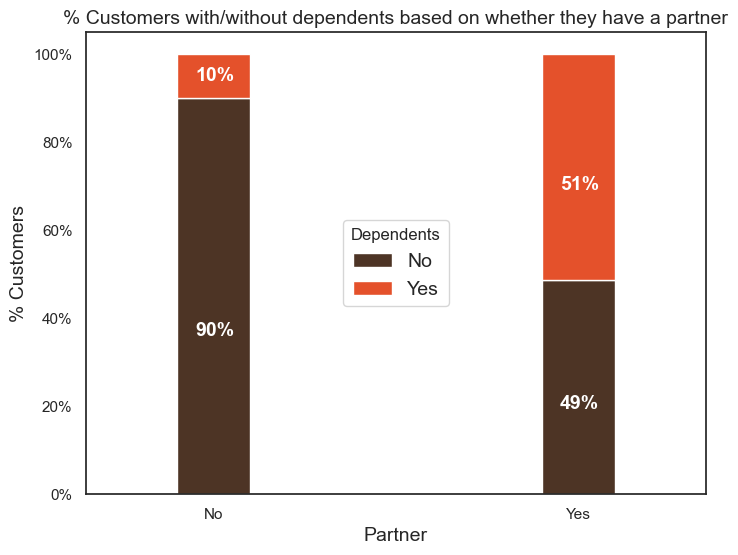

In [16]:
colors = ['#4D3425','#E4512B']
partner_dependents = data.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

I also looked at any differences between the % of customers with/without dependents and partners by gender. There is no difference in their distribution by gender. Additionally, there is no difference in senior citizen status by gender.

### B.) **Customer Account Information**:  Let us now look at the tenure, contract

1. **Tenure**: After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

Text(0.5, 1.0, '# of Customers by their tenure')

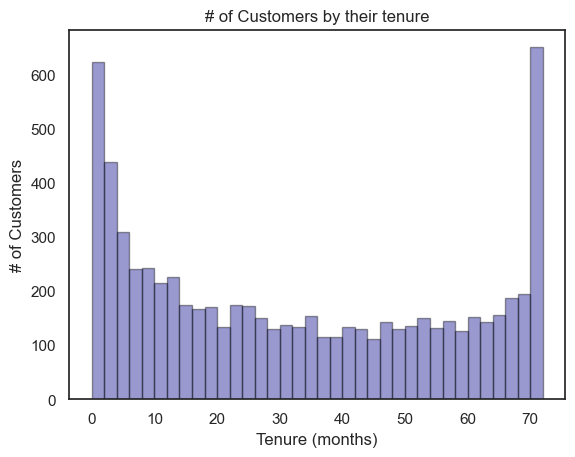

In [17]:
ax = sns.distplot(data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

**2. Contracts:** To understand the above graph, lets first look at the # of customers by different contracts. 

Text(0.5, 1.0, '# of Customers by Contract Type')

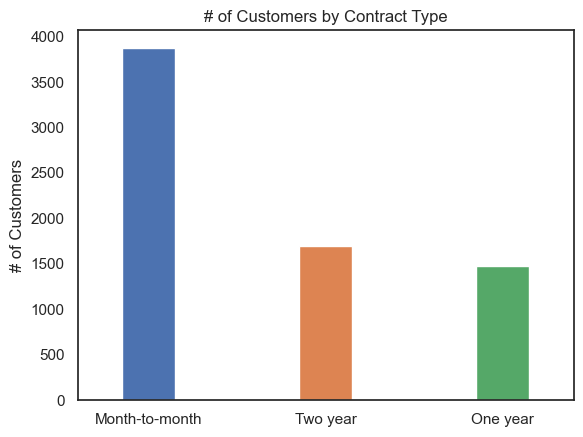

In [18]:
ax = data['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3,color = sns.color_palette())
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

Below we will understand the tenure of customers based on their contract type.

Text(0.5, 1.0, 'Two Year Contract')

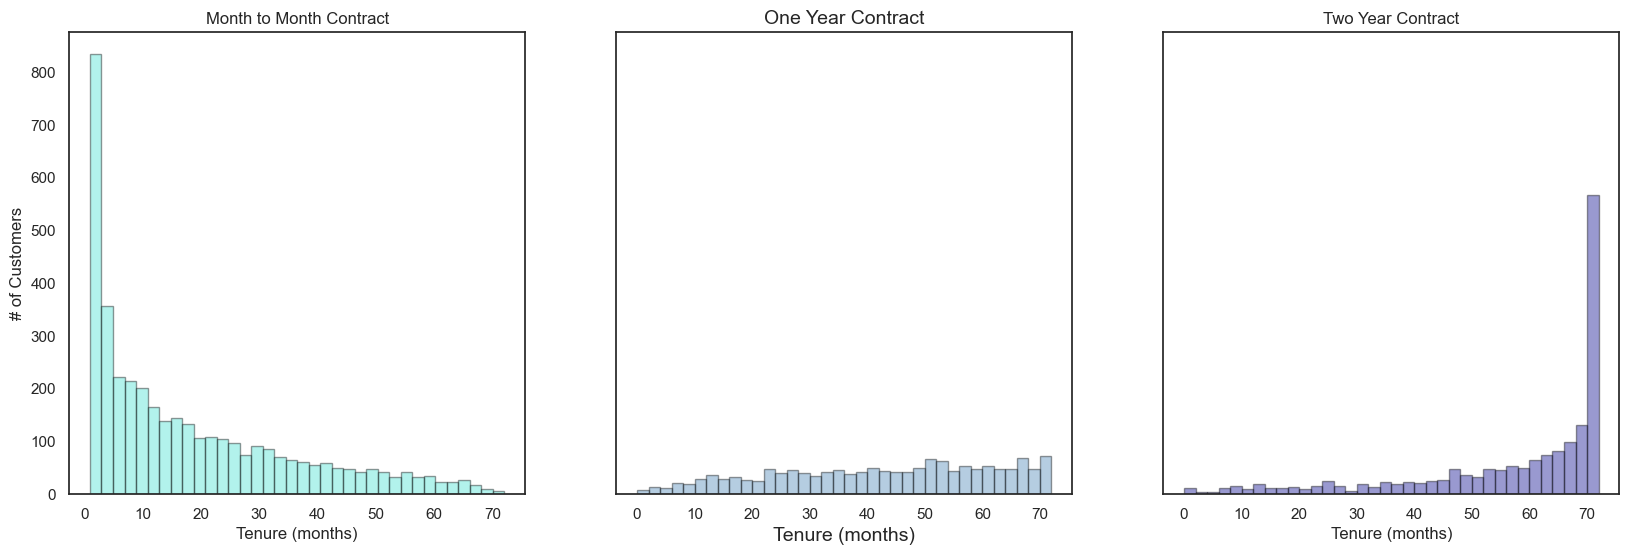

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(data[data['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(data[data['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(data[data['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

This is also what we saw in the earlier chart on correlation with the churn rate.

**C. Let us now look at the distribution of various services used by customers**

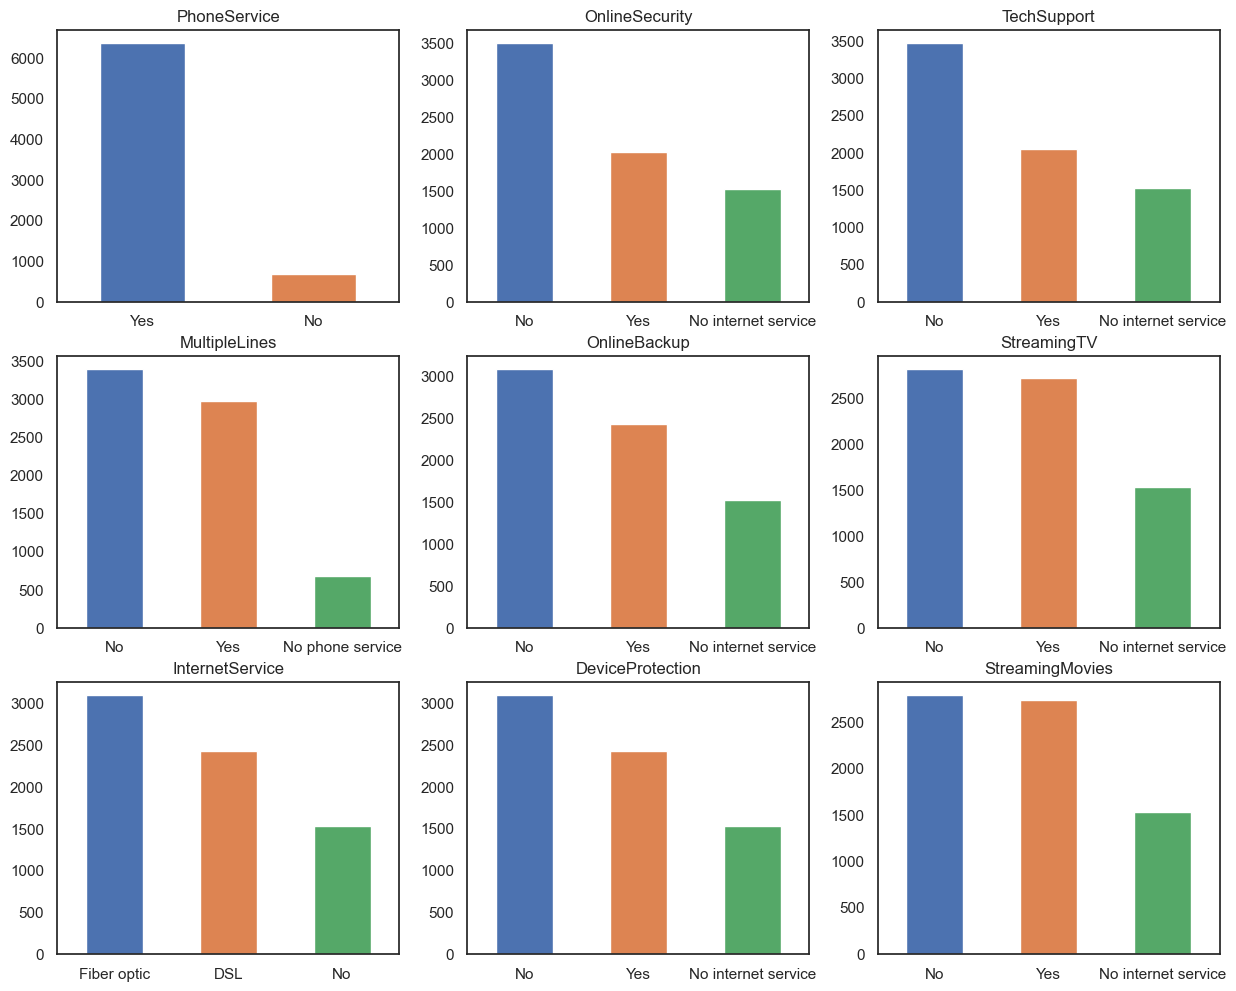

In [20]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0,color = sns.color_palette())
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0,color = sns.color_palette())
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0,color = sns.color_palette())
    ax.set_title(item)

**D.) Now let's take a quick look at the relation between monthly and total charges**

We will observe that the total charges increases as the monthly bill for a customer increases.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

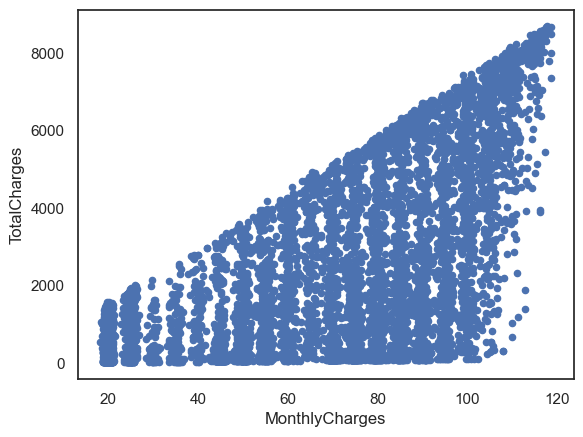

In [21]:
data[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',y='TotalCharges')

### E.) Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.

Lets first look at the churn rate in our data

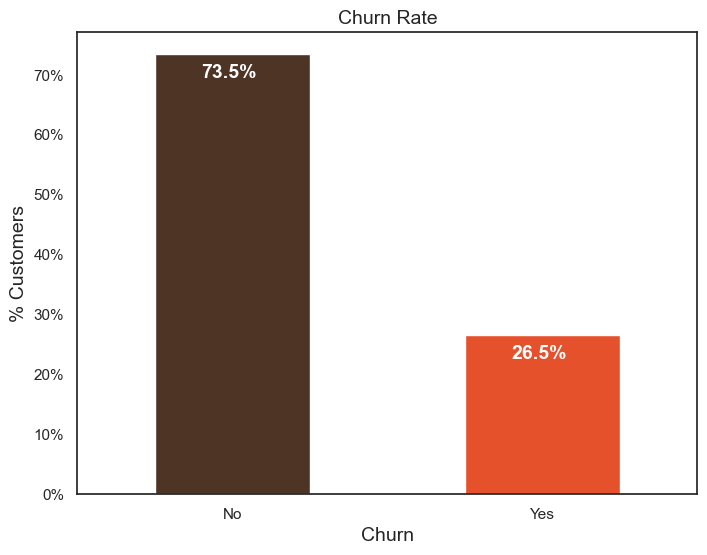

In [22]:
colors = ['#4D3425','#E4512B']
ax = (data['Churn'].value_counts()*100.0 /len(data)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, 
            str(round((i.get_height()/total), 1))+'%',
            color='white',
            weight = 'bold',
            size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

Lets now explore the churn rate by tenure, seniority, contract type, monthly charges and total charges to see how it varies by these variables.

**i.) Churn vs Tenure**: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company. 

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

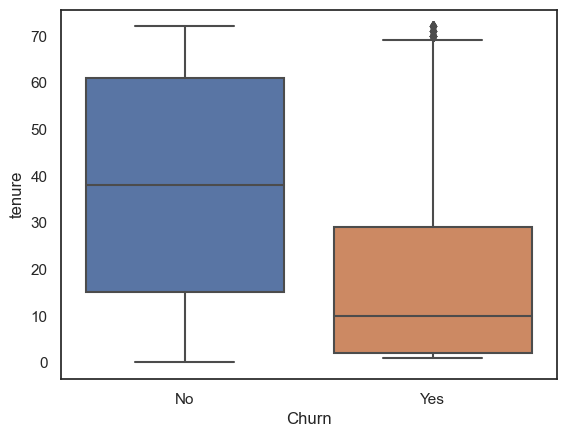

In [23]:
sns.boxplot(x = data.Churn, y = data.tenure)

ii.) Churn by Contract Type: Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

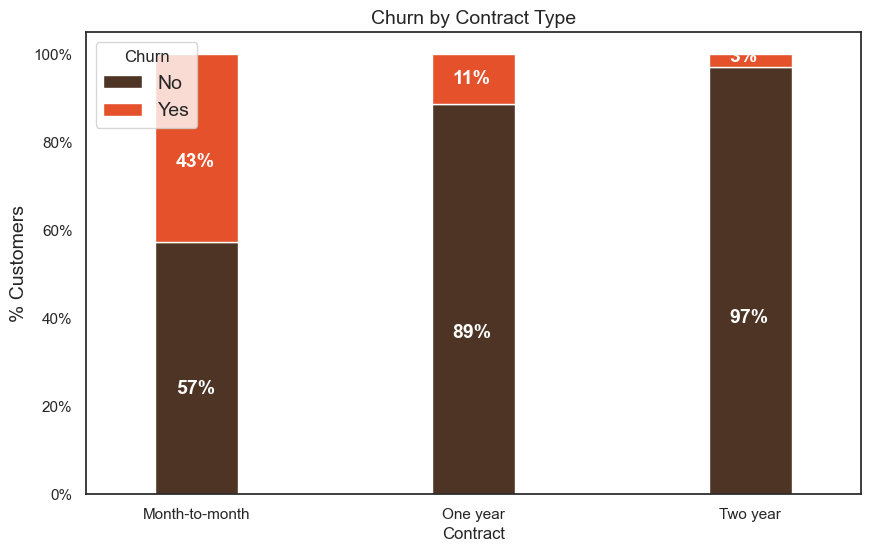

In [24]:
colors = ['#4D3425','#E4512B']
contract_churn = data.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)


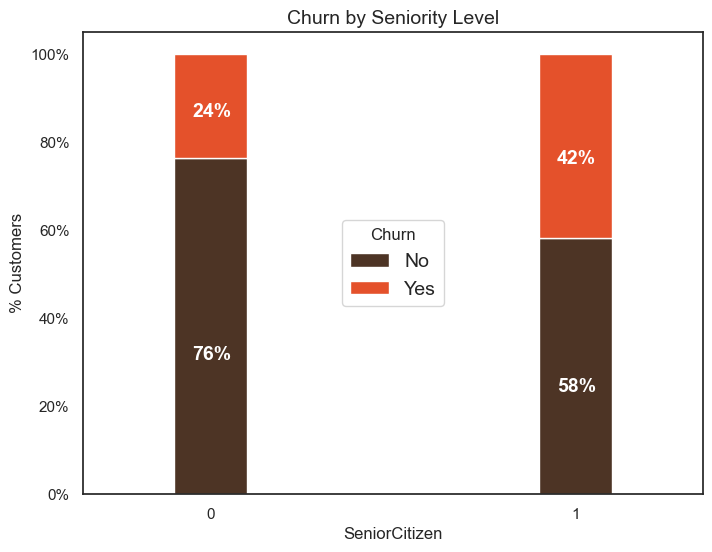

In [24]:
colors = ['#4D3425','#E4512B']
seniority_churn = data.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

iv.) Churn by Monthly Charges: Higher % of customers churn when the monthly charges are high.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

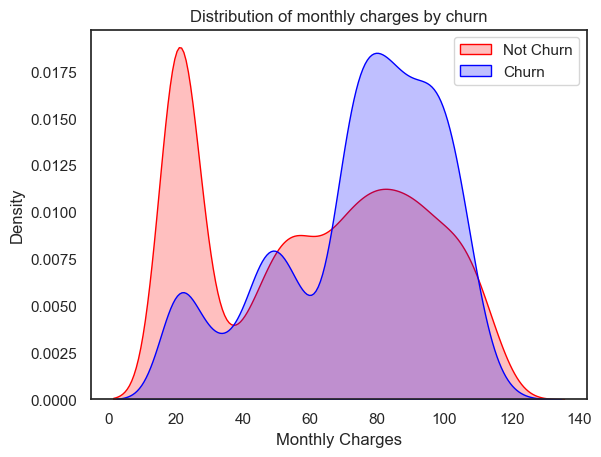

In [25]:
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

v.) Churn by Total Charges: It seems that there is higer churn when the total charges are lower.

Text(0.5, 1.0, 'Distribution of total charges by churn')

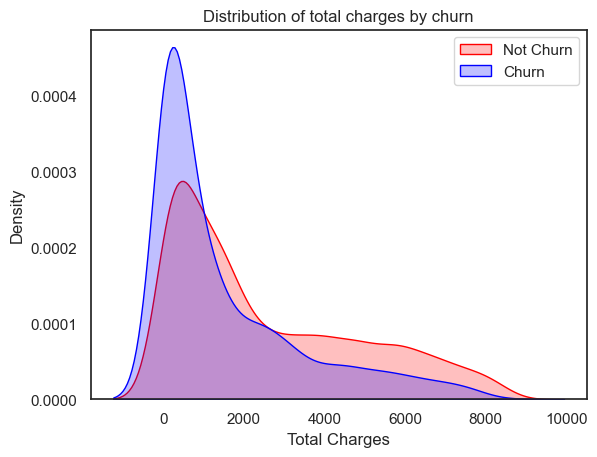

In [26]:
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

### After going through the above EDA we will develop some predictive models and compare them.

### Scaling the data

In [27]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1. This helped me improve the accuracy from 79.7% to 80.7%. Further, you will notice below that the importance of variables is also aligned with what we are seeing in Random Forest algorithm and the EDA we conducted above.

In [28]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**Getting the Accuracy, Confusion Matrix, ROC Curve, ROC-AUC score and TPR/FPR rate also called as Specificity & Sensitivity**

1. **Accuracy** - It is calculated on the test data set
2. **Confusion Matrix** - It tells us how many True Positive/True Negatives and False Positives/False Negatives are present in the prediction

    a. TP: # of customers who will actually default also predicted as default
    
    b. TN: # of customers who won't actually default also predicted as no default
    
    c. FP: # of customers who won't actually default but predicted as default
    
    d. FN: # of customers who will actually default but predicted as no default
    
Note: It is important for a Telecom company to know more about the customers who are likely to default. Thus it is fine to have more False Positives (FP's), however we must have a lower # of FN, because this will predict more risky customers to be not that risky. This is important to keep in mind as we evaluate al the different classification models. We shoud choose the right threshold (even if it eans reducing the accuracy a bit to get better TPR).

3. **ROC curve** - It is a plot between Sensitivity and 1-Specificity predictions for all the different thresholds 

4. **ROC-AUC score** - It is the area under the ROC curve. It helps us compare different models. Higher AUC implies a better model.

### Below is the function to print acuracy score, ROC curvey, ROC-AUC score and confusion matrix

In [53]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
#     #Feature importance
#     coefficients  = pd.DataFrame(eval(model).feature_importances_)
#     column_data   = pd.DataFrame(list(data))
#     coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
#                               right_index= True, how = "left"))
#     coef_sumry.columns = ["coefficients","features"]
#     coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
#     coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
#     trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
#                     name = "coefficients", 
#                     marker = dict(color = coef_sumry["coefficients"],
#                                   colorscale = "Viridis",
#                                   line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=3, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    #fig["layout"]["xaxis6"].update(color = 'white')
    #fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [43]:
# As it is a classification problem MSE is not a appropiate metric
from sklearn import metrics
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Test score {model.score(X_test, y_test)}')
    print("MAE:" , metrics.mean_absolute_error(y_test,model.predict(X_test)))
    print("MSE:" , metrics.mean_squared_error(y_test,model.predict(X_test)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test))))

### Function for Cross Validation

In [44]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [45]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### 1. Light GBM Without Hyperparameter Tuning

In [54]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=1500, random_state = 42)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

model_performance('lgbm_clf')

Wall time: 1.48 s


### Randomized GridSearch

In [34]:
random_state = 42

In [35]:
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 200

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'colsample_bytree': 0.6247240713084175, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_samples': 120, 'min_child_weight': 100.0, 'n_estimators': 2000, 'num_leaves': 24, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 0.5673991135726937} 


**Light GBM after Random search CV**

In [55]:
%%time
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

model_performance('lgbm_clf')

Wall time: 3 s


### Cross Validation Light GBM ( 5CVs)

In [37]:
cross_val_metrics(lgbm_clf)

[accuracy] : 0.80747 (+/- 0.00856)
[precision] : 0.67238 (+/- 0.02206)
[recall] : 0.53612 (+/- 0.01509)
[f1] : 0.59646 (+/- 0.01632)
[roc_auc] : 0.84848 (+/- 0.01010)


AxesSubplot(0.125,0.11;0.775x0.77)


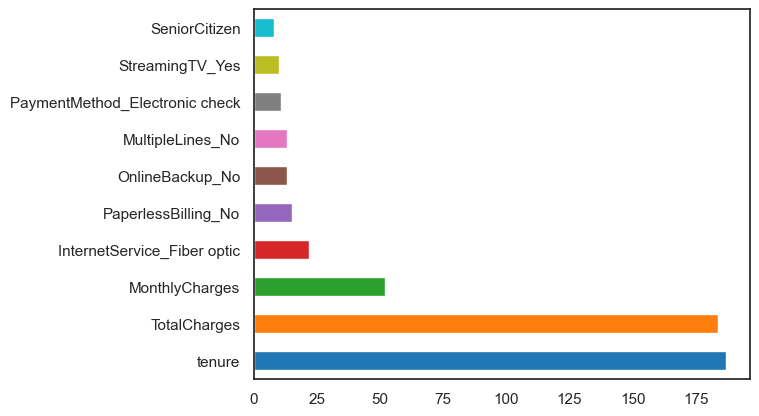

In [40]:
# To get the weights of all the variables
weights = pd.Series(lgbm_clf.feature_importances_,
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='barh',color = sns.color_palette("tab10")))

### 2. Logistic Regression

Defining function for Logistic Regression

In [106]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
#     #Feature importance
#     coefficients  = pd.DataFrame(eval(model).feature_importances_)
#     column_data   = pd.DataFrame(list(data))
#     coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
#                               right_index= True, how = "left"))
#     coef_sumry.columns = ["coefficients","features"]
#     coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
#     coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
#     trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
#                     name = "coefficients", 
#                     marker = dict(color = coef_sumry["coefficients"],
#                                   colorscale = "Viridis",
#                                   line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=3, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    #fig["layout"]["xaxis6"].update(color = 'white')
    #fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [107]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

lgr_clf = LogisticRegression()
lgr_clf.fit(X_train, y_train)
y_pred = lgr_clf.predict(X_test)
y_score = lgr_clf.predict_proba(X_test)[:,1]

model_performance('lgr_clf')

In [108]:
cross_val_metrics(lgr_clf)

[accuracy] : 0.80278 (+/- 0.00763)
[precision] : 0.65310 (+/- 0.01512)
[recall] : 0.54736 (+/- 0.02228)
[f1] : 0.59548 (+/- 0.01873)
[roc_auc] : 0.84474 (+/- 0.01103)


AxesSubplot(0.125,0.11;0.775x0.77)


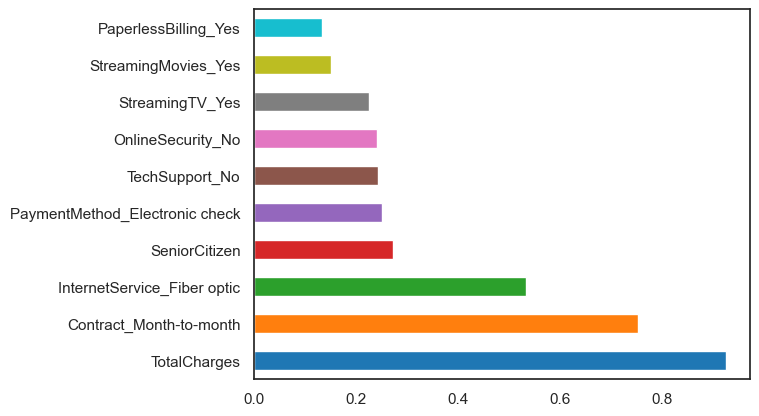

In [74]:
# To get the weights of all the variables
weights = pd.Series(lgr_clf.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='barh',color = sns.color_palette("tab10")))

AxesSubplot(0.125,0.11;0.775x0.77)


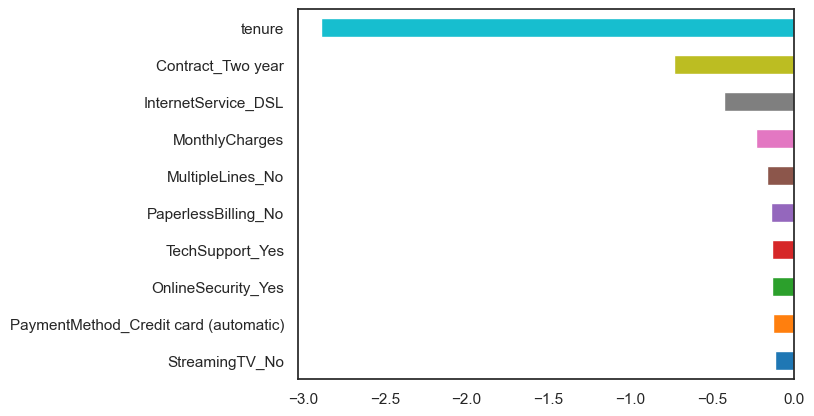

In [75]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='barh',color = sns.color_palette("tab10")))

### Observations:

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

* As we saw in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions
* Having DSL internet service also reduces the proability of Churn
* Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening.

Any hypothesis on the above would be really helpful!

#### 3. Supprt Vector Machines (SVMs)

In [110]:
model_svm = SVC(kernel='linear') 
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_test)

model_performance('model_svm')

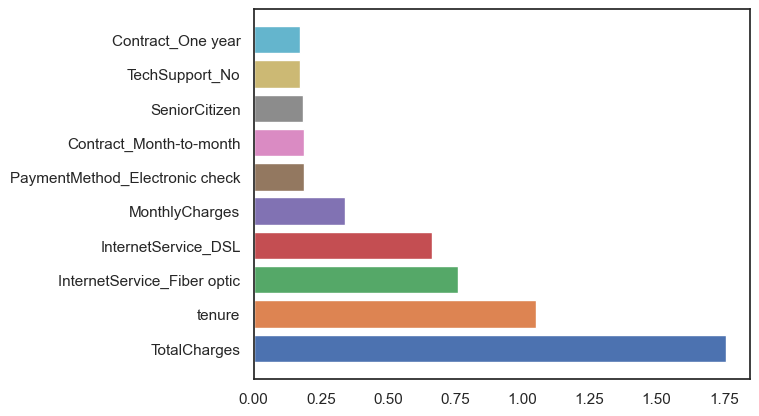

In [78]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center',color=sns.color_palette())
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
feature_names = X.columns.values 


# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(model_svm.coef_[0]), feature_names, top=10)

### 4. AdaBoost

In [62]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier(random_state = 42)
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
adb_clf.fit(X_train,y_train)
y_pred = adb_clf.predict(X_test)
y_score = adb_clf.predict_proba(X_test)[:,1]

model_performance('adb_clf')


**AdaBoost - Cross Validation - 5 CVs**

In [50]:
cross_val_metrics(adb_clf)

[accuracy] : 0.80717 (+/- 0.00698)
[precision] : 0.67313 (+/- 0.02153)
[recall] : 0.53504 (+/- 0.01415)
[f1] : 0.59596 (+/- 0.01240)
[roc_auc] : 0.84676 (+/- 0.01196)


<AxesSubplot:>

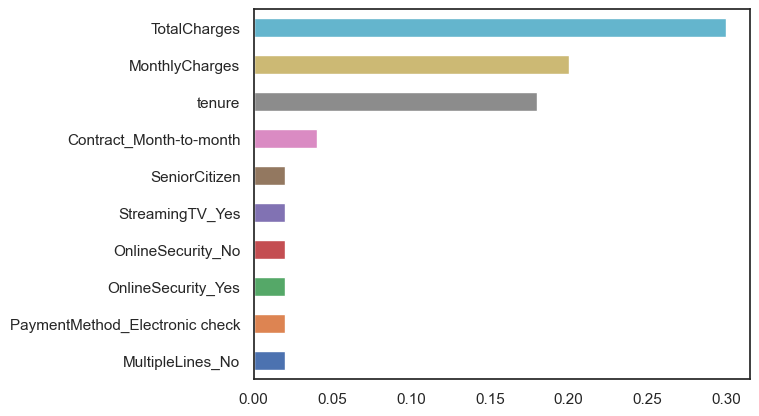

In [63]:
importances = adb_clf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = sns.color_palette())

### 5. Random Forest after Random Gridsearch

In [137]:
model_rf = RandomForestClassifier()
# create the random grid
param_test  =  {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 20, 40, 50, 70, 80, 100, None],
               'min_samples_split': [2, 5, 10, 15],
               'min_samples_leaf': [1, 2, 5, 10],
               'bootstrap': [True, False]}

# randomized search CV
grid_search = RandomizedSearchCV(estimator=model_rf,
                                 param_distributions=param_test,
                                 n_iter = 100,
                                 cv=3,
                                 random_state=42,
                                 n_jobs = -1,
                                 verbose=2)

#grid_search = RandomizedSearchCV(estimator=model_rf,random_grid)
grid_search.fit(X_train, y_train)
opt_parameters =  grid_search.best_params_
print(opt_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1155, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [142]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(**opt_parameters)
#model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
#                                  random_state =50, max_features = "auto",
#                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred = model_rf.predict(X_test)
y_score = model_rf.predict_proba(X_test)[:,1]

model_performance('model_rf')

<AxesSubplot:>

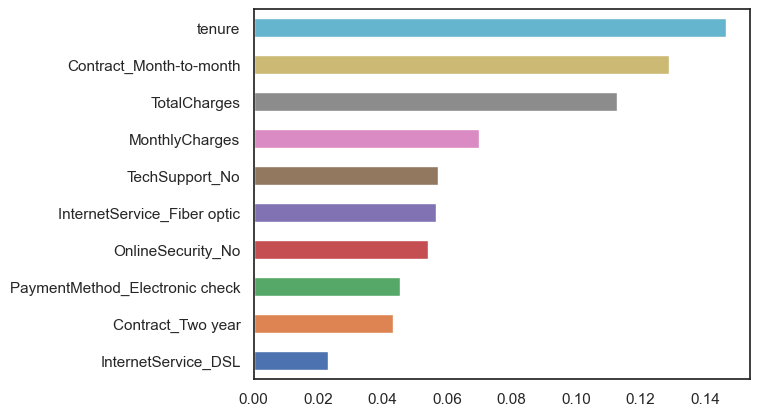

In [143]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = sns.color_palette())

### Observations:

* From random forest algorithm, monthly contract, tenure and total charges are the most important predictor variables to predict churn.
* The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

**6. XG Boost**

In [91]:
from xgboost import XGBClassifier
from sklearn import metrics
model_XG = XGBClassifier(random_state = 42)
model_XG.fit(X_train, y_train)
y_pred = model_XG.predict(X_test)
model_performance('model_XG')

<AxesSubplot:>

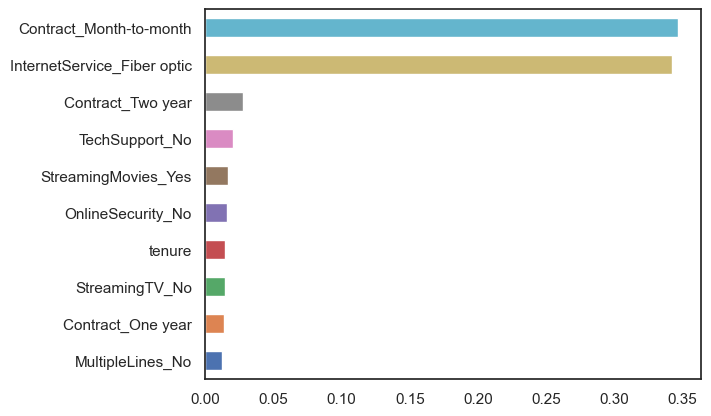

In [92]:
importances = model_XG.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = sns.color_palette())

**7. Decision Tree**

In [97]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion = "gini",random_state = 42,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
y_pred = clf_gini.predict(X_test)
y_score = clf_gini.predict_proba(X_test)[:,1]

model_performance('clf_gini')

<AxesSubplot:>

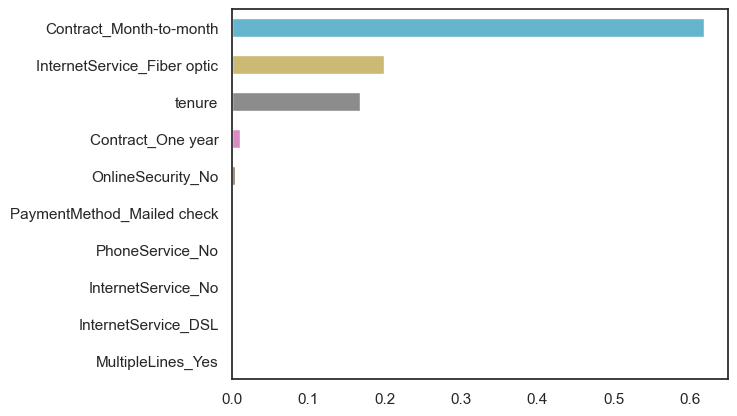

In [98]:
importances = clf_gini.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = sns.color_palette())

In [100]:
from sklearn.tree import DecisionTreeClassifier
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 42,max_depth = 3, min_samples_leaf = 5)
clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)
y_score = clf_entropy.predict_proba(X_test)[:,1]

model_performance('clf_entropy')

<AxesSubplot:>

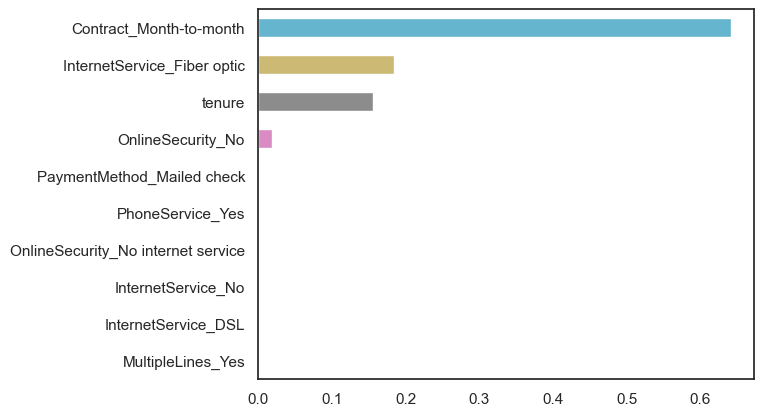

In [101]:
importances = clf_entropy.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = sns.color_palette())

### SHAP plot of the best fitted (according to AUC) model LightGBM.

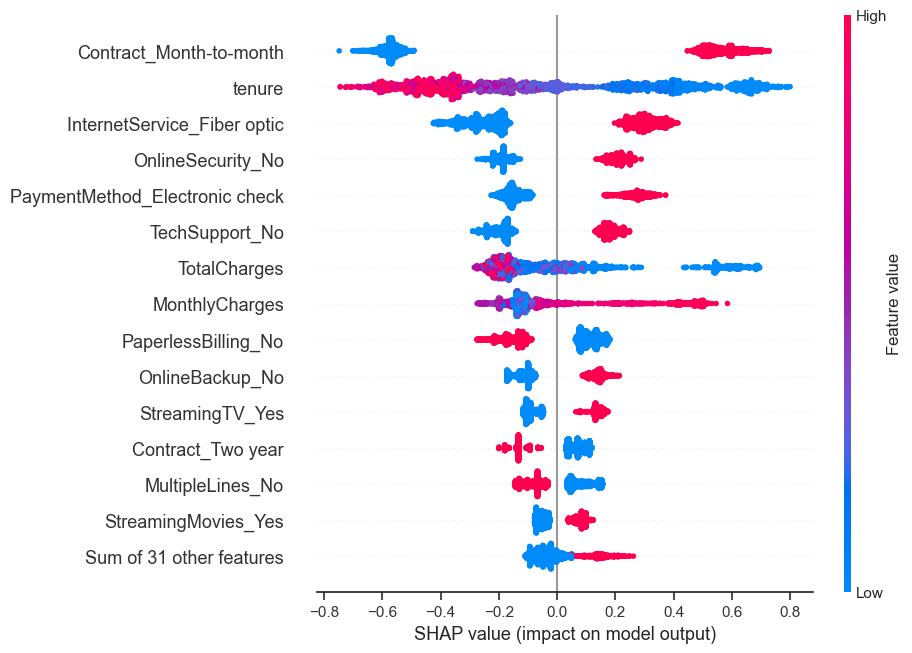

In [100]:
# Initialize the SHAP explainer
# Calculate SHAP values for the test set
explainer = shap.Explainer(lgbm_clf)
shap_values = explainer(X_test)

# beeswarm plot
shap.plots.beeswarm(shap_values[:, :, 1],max_display=15,order=shap.Explanation.abs.mean(0))


### Conclusion

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

* As we saw in the above plot, tenure along with contract two year have the most negative relation with Churn as predicted by LightGBM.
* Having month to month contract also reduces the proability of Churn. So it is advisable to introduce more varites of plans of one month duration.
* Also, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening.
* Moreover, churn rate is high for high monthly charges. So, here we have to optimize between profit and monthly charges.